# Topic Modelling in the Reuters 21578 Dataset with Latent Dirichlet Allocation

## Selecting Number of Topics using Coherence vs Perplexity

### Logging

You may want to keep the logging level at `WARNING`, unless you want to see lots of information coming back at you.

In [1]:
import logging
logging.basicConfig(
    format="%(asctime)s : %(levelname)s : %(message)s", 
    level=logging.WARNING
)

### Environment Set-up

Please use the Anaconda Distribution to create a virtual environment for running this example notebook. 

Create your virtual environment with `conda` with:

    conda env create -n LDA-reuters -f environment.yml

The key dependencies in this notebook are:

1. Python 3.9
2. [gensim](https://radimrehurek.com/gensim/)
3. [PyLDAVis](https://github.com/bmabey/pyLDAvis)

In [2]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import pickle
import pyLDAvis
import pyLDAvis.gensim_models   # bug?
import time

from eda.corpus.reuterscorpus import ReutersCorpus

from gensim.models import CoherenceModel, LdaMulticore
from gensim.corpora import Dictionary, MmCorpus
from os import path
from tqdm.notebook import tqdm

In [3]:
datadir = path.abspath(path.join(os.getcwd(), "data"))

----

### Dictionary and Corpus creation

In [4]:
# Read in the corpus from within the archive file
fin = path.join(datadir, "reuters21578.tar.gz")
rc = ReutersCorpus(fin)

In [5]:
# Filter out some of the more common words,
# and some of the less-common ones as well
rc.dictionary.filter_extremes(no_below=20, no_above=0.1)
rc.dictionary.compactify()

In [6]:
# Serialize the Reuters 21578 corpus
fout = path.join(datadir, "reuters21578.mm")
MmCorpus.serialize(fout, rc)

In [7]:
# Save the dictionary to file as text
fout = path.join(datadir, "reuters21578.dict.txt")
rc.dictionary.save_as_text(fout)

In [8]:
# Save the text of the corpus for later use
texts = list(rc.get_texts())

fout = path.join(datadir, "texts.pkl")
with open(fout, "wb") as f:
    pickle.dump(texts, f)

----

### Coherence vs Perplexity

Plot topic coherence vs perplexity across a range of topic numbers for LDA on the Reuters dataset.

In [9]:
fin = path.join(datadir, "reuters21578.dict.txt")
dictionary = Dictionary.load_from_text(fin)

In [10]:
fin = path.join(datadir, "reuters21578.mm")
corpus = MmCorpus(fin)

In [11]:
fin = path.join(datadir, "texts.pkl")
with open(fin, "rb") as f:
    texts = pickle.load(f)

We'll try out a range of topic numbers.

In [12]:
start = 5
limit = 100
step = 5

In [13]:
lda_models = {}
coherence_vals = []
perplexity_vals = []

for num_topics in tqdm(range(start, limit, step)):
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=20,
        workers=mp.cpu_count()-1
    )
    lda_models[num_topics] = lda_model
    
    perplexity_vals.append(
        np.exp2(-lda_model.log_perplexity(corpus))
    )
    
    coherence_model_lda = CoherenceModel(
        model=lda_model, 
        texts=texts, 
        dictionary=dictionary, 
        coherence="c_v"
    )
    coherence_vals.append(
        coherence_model_lda.get_coherence()
    )

/Users/brooke/anaconda3/envs/LDA-reuters/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/brooke/anaconda3/envs/LDA-reuters/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/brooke/anaconda3/envs/LDA-reuters/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/brooke/anaconda3/envs/LDA-reuters/lib/python3.9/site-packages/ipyw

  0%|          | 0/19 [00:00<?, ?it/s]

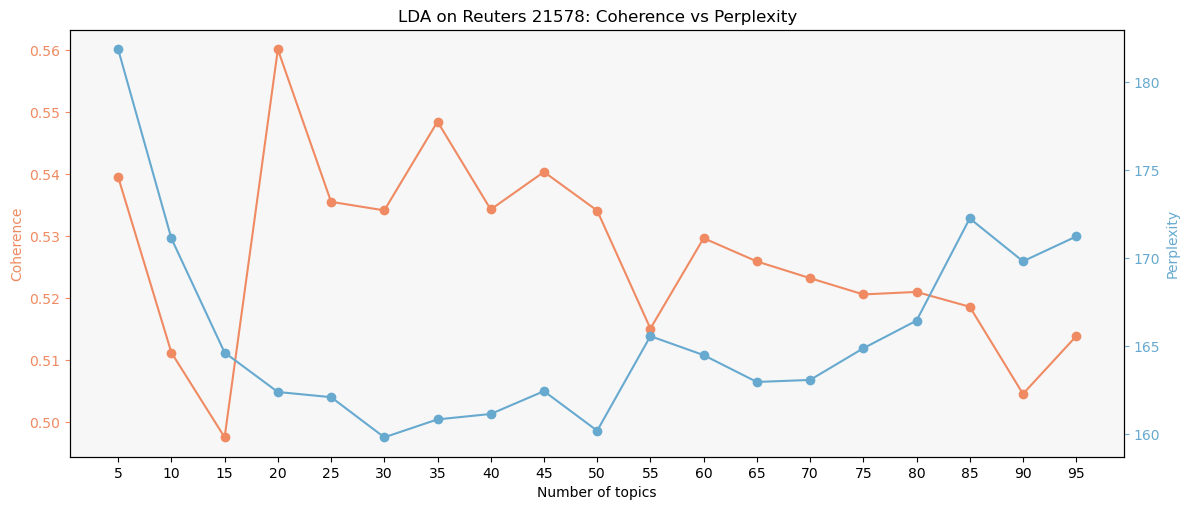

In [14]:
x = range(start, limit, step)

c1, bgcolor, c2 = ["#ef8a62", "#f7f7f7", "#67a9cf"]


fig, ax1 = plt.subplots(figsize=(12,5))

# coherence plot
ax1.plot(x, coherence_vals, "o-", color=c1)
ax1.set_xlabel("Number of topics")
ax1.set_ylabel("Coherence", color=c1)
ax1.tick_params("y", colors=c1)

# perplexity plot
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, "o-", color=c2)
ax2.set_ylabel("Perplexity", color=c2)
ax2.tick_params("y", colors=c2)

# x-axis is shared 
ax1.set_xticks(x)
ax1.set_facecolor(bgcolor)

fig.tight_layout()
plt.title("LDA on Reuters 21578: Coherence vs Perplexity")
plt.show()

----

### Dive into an LDA model with `pyLDAvis`

Interactively explore a resulting LDA model for a given `num_topics` value with [`pyLDAvis`](https://github.com/bmabey/pyLDAvis).

In [18]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(
    lda_models[20],
    corpus, 
    dictionary, 
    n_jobs=1, 
    sort_topics=False
)

pyLDAvis.display(vis)